In [121]:
import os
import scanpy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
import sys
import pandas as pd
import numpy as np
import scvi
scvi.settings.seed = 0
from sklearn.neighbors import KNeighborsClassifier

sys.path.append('..')
from custom_functions import *

import warnings
warnings.filterwarnings("ignore")

save_format = "svg" 

Seed set to 0


In [122]:
#dataset=sys.argv[1]
dataset='mouse'

In [123]:
data_folder = "data/mouse"
analysis_name='mouse_pijuan'

if not os.path.isdir(f"results/{analysis_name}"):
    os.makedirs(f"results/{analysis_name}", exist_ok=True)
if not os.path.isdir(f"results/{analysis_name}/umap_genes"):
    os.makedirs(f"results/{analysis_name}/umap_genes", exist_ok=True)

# 0. Construct AnnData

In [124]:
construct_anndata=False

In [125]:
if construct_anndata:    
    adata=sp.read_mtx(f'{data_folder}/raw_counts.mtx').T
    # load genes
    genes=pd.read_csv(f'{data_folder}/genes.tsv', sep="\t", index_col=None, header=None)
    adata.var=genes
    adata.var.columns=["gene_id","gene_name"]
    adata.var_names=adata.var.iloc[:,1]
    # load genes
    cells=pd.read_csv(f'{data_folder}/meta.tab', sep="\t", index_col=None)
    adata.obs=cells
    adata[adata.obs["cluster"].isna(),:]
    adata.obsm["X_umap"] = adata.obs[["umapX","umapY"]].values
        

## Save Anndata file

In [126]:
if construct_anndata:
    adata.write(f'{data_folder}/{analysis_name}.h5ad')

# 1. Marker genes 

In [127]:
genes = pd.read_csv('markers.txt', header=None).iloc[:,0].values

In [128]:
for gene in genes:
    for t in adata.obs["stage"].unique():
        fig,ax = plt.subplots(1,1,figsize=[2.32,2.32])

        # gene expression
        hue = adata[(adata.obs.stage==t).values,gene].X.toarray()[:,0]
        sns.scatterplot(x=adata.obsm["X_umap"][:,0],y=adata.obsm["X_umap"][:,1],c="lightgray",s=2,ax=ax)
        sns.scatterplot(x=adata[adata.obs.stage==t].obsm["X_umap"][:,0],y=adata[adata.obs.stage==t].obsm["X_umap"][:,1],hue=hue,s=2,ax=ax)

        ax.set_title(gene, fontsize=7)
        ax.legend(title=t, title_fontsize=5, prop={'size':5}, loc=(1.01,0.005))

        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        
        os.makedirs(f'results/{analysis_name}/umap_genes/', exist_ok=True)
        fig.savefig(f"results/{analysis_name}/umap_genes/umap_{gene}_{t}.{save_format}", dpi=300, bbox_inches='tight')    
        plt.close()

# 2. Correlation between genes

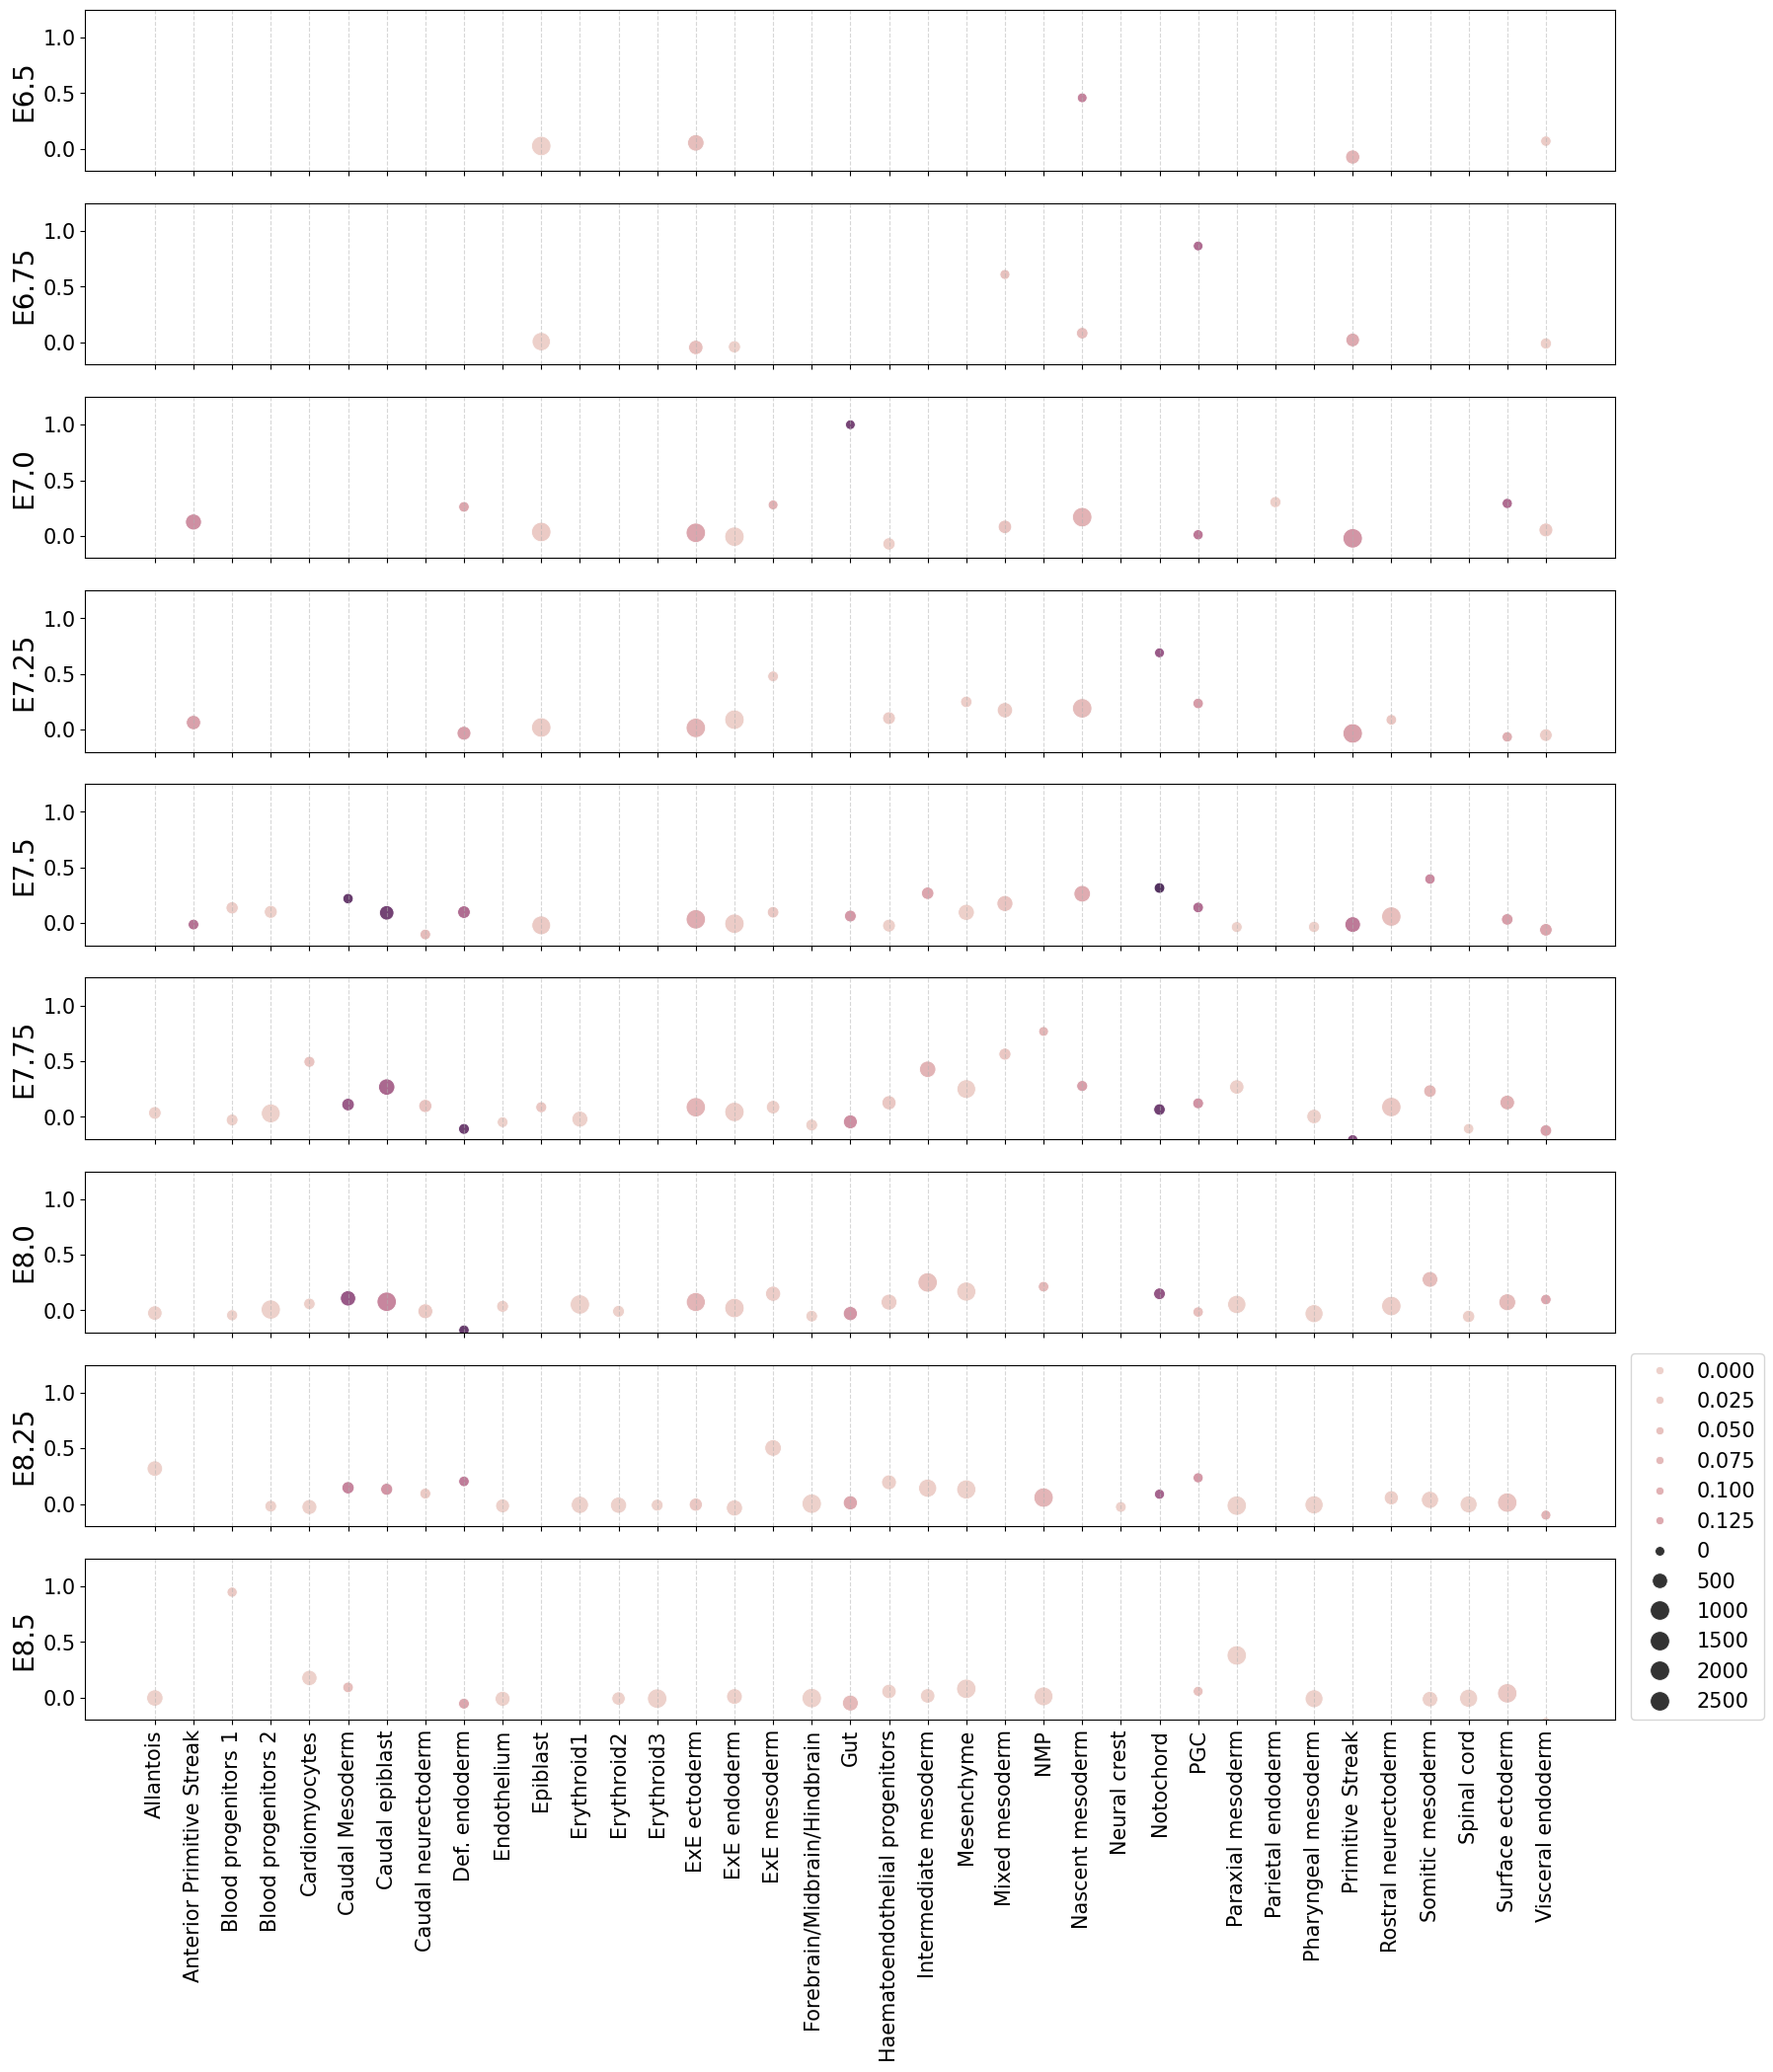

In [131]:
gene1_name = "T"
gene2_name = "Cdh1"

stages = np.sort(adata.obs["stage"].unique())
stages = stages[stages != "mixed_gastrulation"]

fig, ax = plt.subplots(len(stages), 1, figsize=[20, 2.5 * len(stages)], sharex=True)
for i,t in enumerate(stages):

    cs = []
    ss = []
    cols = []
    for celltype in adata.obs["celltype"].unique():
        gene1 = adata[(adata.obs.stage==t).values, gene1_name].X.toarray()[:,0]
        gene2 = adata[(adata.obs.stage==t).values, gene2_name].X.toarray()[:,0]
        ann = adata[(adata.obs.stage==t).values,:].obs["celltype"].values == celltype
        c = np.corrcoef(gene1[ann],gene2[ann])[0,1]
        s = sum(ann)
        col = np.nan_to_num(sum((gene1[ann]*gene2[ann]) > 0) / sum(ann), nan=0)
        cs.append(c)
        ss.append(s)
        cols.append(col)

    sns.scatterplot(x= adata.obs["celltype"].unique(), y=cs, hue=cols, size=ss, hue_norm=(0,0.7), size_norm=(0,1000), sizes=(50,200), ax=ax[i]) 
    ax[i].set_ylabel(t, fontsize=20)
    ax[i].set_ylim(-0.2,1.25)
    ax[i].set_yticklabels(ax[i].get_yticklabels(), fontsize=15)
    ax[i].grid(axis='x', linestyle='--', alpha=0.5, zorder=-1)
    if i != len(stages)-1:
        try:
            ax[i].get_legend().remove()
        except:
            None
    else:
        ax[i].legend(loc=(1.01,0), fontsize=15)
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, fontsize=15)

fig.savefig(f"results/{analysis_name}/correlation_plot_{gene1_name}_{gene2_name}.{save_format}", dpi=300, bbox_inches='tight')    
